In [15]:
import numpy as np
import matplotlib.pyplot as plt
from libemag.emag_initials import *
from libemag.plots import field_plot
import sympy as smp
from scipy.integrate import dblquad, tplquad
from joblib import Parallel, delayed

## สนามไฟฟ้าจากประจุใด ๆ
$$\mathbf{dE}=\frac{dq}{4\pi\epsilon_0}\frac{\mathbf{r-r'}}{|\mathbf{r-r'}|^3}$$
$$\mathbf{E(r)}=\int\mathbf{dE}$$

### Line Charge
$$dq=\rho_l(r')|d\mathbf{r'}|$$

Parameterised
$$dq=\rho_l(r')\left\|\frac{d\mathbf{r'}}{dt}\right\|dt$$

## Surface Charge
$$dq=\rho_s(r')ds$$
Parameterised
$$dq=\rho_l(r')\left\|\frac{d\mathbf{r'}}{du}\times\frac{d\mathbf{r'}}{dv}\right\|dudv$$

## Volume Charge (Cylinder)
$$dq=\rho_v(r')dv$$
Parameterised
$$dq=\rho_v(r')\left\|\frac{d\mathbf{r'}}{d\rho}\times\frac{d\mathbf{r'}}{d\phi}\right\|d\rho d\phi dz$$

# HW1
<img src="https://github.com/nayot/emag/blob/main/pics/Emag000.png?raw=true" alt="Image" style="width: 50%;"/>
(ก) จงเขียนโปรแกรมเพื่อหาสนามไฟฟ้า $\mathbf{E}(x, y, z)$ เนื่องจากประจุไฟฟ้ารูปทรงกระบอกตัน ที่มีความหนาแน่นประจุ $\rho_v=1~\mu C/m^3$ มีรัศมี $1~cm$ และมีความยาว $10~m$


In [4]:
x, y, z, zp = smp.symbols("x, y, z, z'", real=True)
rho, phi = smp.symbols('rho, phi', real=True, positive=True)

r = smp.Matrix([x, y, z])
rp = smp.Matrix([rho * smp.cos(phi),
                rho * smp.sin(phi),
                zp])
R = r - rp
R

Matrix([
[-rho*cos(phi) + x],
[-rho*sin(phi) + y],
[           z - z']])

In [8]:
smp.diff(rp, rho).cross(smp.diff(rp, phi)).norm().simplify()

rho

In [9]:
rho_v = 1e-6

dqdv = rho_v * smp.diff(rp, rho).cross(smp.diff(rp, phi)).norm().simplify()
dqdv

1.0e-6*rho

In [10]:
dEdv = dqdv / (4. * pi * epsilon_0) * R / R.norm()**3
dEdv

Matrix([
[8987.55179226117*rho*(-rho*cos(phi) + x)/((z - z')**2 + (rho*sin(phi) - y)**2 + (rho*cos(phi) - x)**2)**(3/2)],
[8987.55179226117*rho*(-rho*sin(phi) + y)/((z - z')**2 + (rho*sin(phi) - y)**2 + (rho*cos(phi) - x)**2)**(3/2)],
[           8987.55179226117*rho*(z - z')/((z - z')**2 + (rho*sin(phi) - y)**2 + (rho*cos(phi) - x)**2)**(3/2)]])

In [14]:
integrand_x = smp.lambdify([rho, phi, zp, x, y, z], dEdv[0])
integrand_y = smp.lambdify([rho, phi, zp, x, y, z], dEdv[1])
integrand_z = smp.lambdify([rho, phi, zp, x, y, z], dEdv[2])

In [16]:
def E(x, y, z):
    Ex = tplquad(integrand_x, -5., 5., 0., 2. * pi, 0., 1.e-2, args=(x, y, z))[0]
    Ey = tplquad(integrand_y, -5., 5., 0., 2. * pi, 0., 1.e-2, args=(x, y, z))[0]
    Ez = tplquad(integrand_z, -5., 5., 0., 2. * pi, 0., 1.e-2, args=(x, y, z))[0]
    return np.array([Ex, Ey, Ez])

E(1, 2, 3)

array([0.92033008, 1.84066016, 0.60126171])

(ข) จงพล็อตขนาดของสนามไฟฟ้า $|\mathbf{E}(x, 0, 0)|$ เมื่อ $y=z=0$

In [17]:
# Parallel Processing
from joblib import Parallel, delayed
X = np.linspace(-3e-2, 3e-2, 200)

# Function to vectorize
def compute_E_field(x, y, z):
    result = E(x, y, z)
    return np.linalg.norm(result)

E_field = Parallel(n_jobs=-1)(delayed(compute_E_field)(x, 0., 0.) for x in X)

/Users/nayot/anaconda3/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nayot/anaconda3/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nayot/anaconda3/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nayot/anaconda3/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: Integr

Text(0, 0.5, '$|\\mathbf{E}(x, 0, 0)|~(V/m)$')

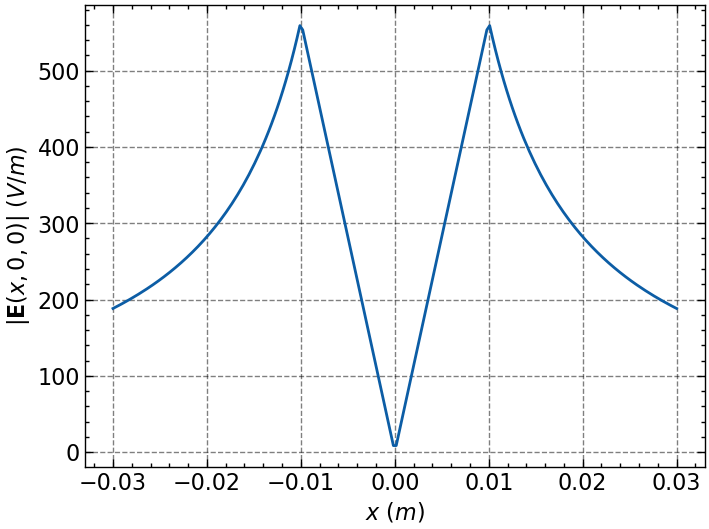

In [20]:
plt.plot(X, E_field)
plt.xlabel(r'$x~(m)$')
plt.ylabel(r'$|\mathbf{E}(x, 0, 0)|~(V/m)$')

In [25]:
def E2D(x, y):
    return E(x, y, 0.)[:2]

E2D(1, 1)

array([2.71693623, 2.71693623])

/Users/nayot/anaconda3/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nayot/anaconda3/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nayot/anaconda3/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:1233: IntegrationWarning: The algorithm does not converge. 

<Axes: xlabel='x', ylabel='y'>

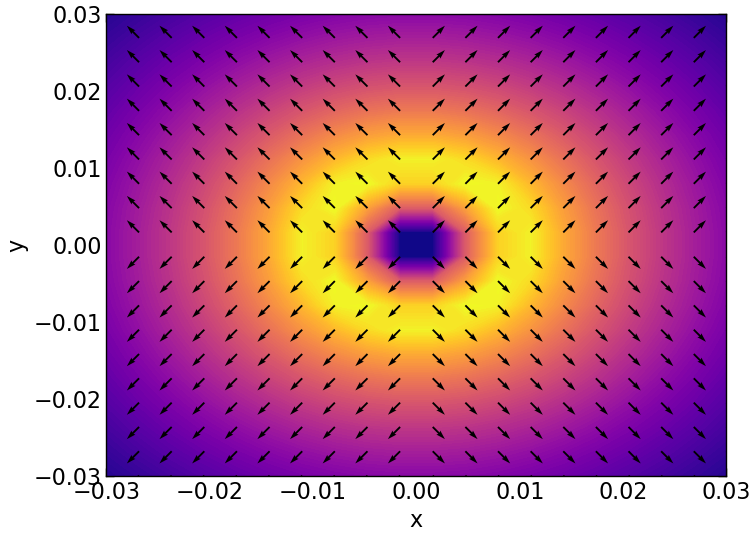

In [26]:
plt.figure(figsize=(7, 7))
field_plot(E2D, x_min=-3e-2, x_max=3e-2, y_min=-3e-2, y_max=3e-2, contour=True)

# HW2
<img src="https://github.com/nayot/emag/blob/main/pics/Emag001.png?raw=true" alt="Image" style="width: 50%;"/>
(ก) จงเขียนโปรแกรมเพื่อหาสนามไฟฟ้า $\mathbf{E}(x, y, z)$ เนื่องจากประจุไฟฟ้าทรงกระบอกกลวงแกนร่วม โดยที่ประจุตัวในมีขนาด $10~\mu C$ และประจุตัวนอกมีขนาด $-10~\mu C$ ประจุนี้มีความยาว $10~m$ ให้ประจุตัวในและตัวนอกมีรัศมี $1$ และ $2~cm$ ตามลำดับ

(ข) จงพล็อตขนาดของสนามไฟฟ้า $|\mathbf{E}(x, 0, 0)|$ เมื่อ $y=z=0$